![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# NLP2 Lecture 4 Support Notebook

### Table of Contents
<p>
<div class="lev1">
    <a href="#Pretraining-BERT"><span class="toc-item-num">1&nbsp;&nbsp;</span>
        Pretraining BERT
    </a>
</div>

<div class="lev1">
    <a href="#Natural-Language-Inference-and-the-Dataset"><span class="toc-item-num">2&nbsp;&nbsp;</span>
        Natural Language Inference and the Dataset
    </a>
</div>

<div class="lev1">
    <a href="#Natural-Language-Inference:-Fine-Tuning-BERT"><span class="toc-item-num">3&nbsp;&nbsp;</span>
        Natural Language Inference: Fine-Tuning BERT
    </a>
</div>

# Pretraining BERT
With the BERT model implemented in Section 14.8 (D2L book) and the pretraining examples generated from the WikiText-2 dataset in Section 14.9, we will pretrain BERT on the WikiText-2 dataset in this section.

In [1]:
!pip install -q git+https://github.com/d2l-ai/d2l-en # installing d2

In [2]:
from d2l import torch as d2l
import torch
from torch import nn

# npx.set_np()
d2l.try_all_gpus()

[device(type='cuda', index=0)]

To start, we load the WikiText-2 dataset as minibatches of pretraining examples for masked language modeling and next sentence prediction. The batch size is 512 and the maximum length of a BERT input sequence is 64. Note that in the original BERT model, the maximum length is 512.

In [3]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

## Pretraining BERT
The original BERT has two versions of different model sizes [Devlin et al., 2018]. 
+ The base model ( BERTBASE ) uses 12 layers (Transformer encoder blocks) with 768 hidden units (hidden size) and 12 self-attention heads. 
+ The large model ( BERTLARGE ) uses 24 layers with 1024 hidden units and 16 self-attention heads. Notably, the former has 110 million parameters while the latter has 340 million parameters. For demonstration with ease, we define a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads.

In [4]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

Before defining the training loop, we define a helper function _get_batch_loss_bert. Given the shard of training examples, this function computes the loss for both the masked language modeling and next sentence prediction tasks. Note that the final loss of BERT pretraining is just the sum of both the masked language modeling loss and the next sentence prediction loss.

In [5]:
# Saved in the d2l package for later use
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

Invoking the two aforementioned helper functions, the following train_bert function defines the procedure to pretrain BERT (net) on the WikiText-2 (train_iter) dataset. Training BERT can take very long. Instead of specifying the number of epochs for training as in the train_ch13 function (see Section 13.1), the input num_steps of the following function specifies the number of iteration steps for training.

In [6]:
# Saved in the d2l package for later use
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

We can plot both the masked language modeling loss and the next sentence prediction loss during BERT pretraining.

MLM loss 6.136, NSP loss 0.697
2607.7 sentence pairs/sec on [device(type='cuda', index=0)]
CPU times: user 17.2 s, sys: 3.32 s, total: 20.6 s
Wall time: 20.6 s


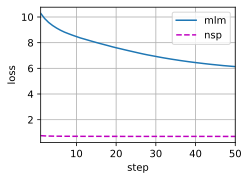

In [7]:
%%time
# around 00:51 minutes with gpu
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## Representing text with BERT
After pretraing BERT, we can use it to represent single text, text pairs, or any token in them. The following function returns the BERT (net) representations for all tokens in tokens_a and tokens_b.

In [8]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

Consider the sentence “a crane is flying”. Recall the input representation of BERT as discussed in Section 14.8.4. After inserting special tokens “$<cls>$” (used for classification) and “$<sep>$” (used for separation), the BERT input sequence has a length of six. Since zero is the index of the “$<cls>$” token, encoded_text[:, 0, :] is the BERT representation of the entire input sentence. To evaluate the polysemy token “crane”, we also print out the first three elements of the BERT representation of the token.

In [9]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([-1.4563, -0.3301,  1.6417], device='cuda:0', grad_fn=<SliceBackward>))

Now consider a sentence pair “a crane driver came” and “he just left”. Similarly, encoded_pair[:, 0, :] is the encoded result of the entire sentence pair from the pretrained BERT. Note that the first three elements of the polysemy token “crane” are different from those when the context is different. This supports that BERT representations are context-sensitive.

In [10]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-1.5431, -0.6221,  1.8446], device='cuda:0', grad_fn=<SliceBackward>))

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-4-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Natural Language Inference and the Dataset
When there is a need to decide whether one sentence can be inferred from another, or eliminate redundancy by identifying sentences that are semantically equivalent, we need to be able to reason over pairs of text sequences. 

## Natural Language Inference
Natural language inference studies whether a hypothesis can be inferred from a premise, where both are a text sequence. In other words, natural language inference determines the logical relationship between a pair of text sequences. Such relationships usually fall into three types:

+ Entailment: the hypothesis can be inferred from the premise.

+ Contradiction: the negation of the hypothesis can be inferred from the premise.

+ Neutral: all the other cases.

Natural language inference is also known as the recognizing textual entailment task. For example, the following pair will be labeled as entailment because “showing affection” in the hypothesis can be inferred from “hugging one another” in the premise.

> Premise: Two women are hugging each other.

> Hypothesis: Two women are showing affection.

The following is an example of contradiction as “running the coding example” indicates “not sleeping” rather than “sleeping”.

> Premise: A man is running the coding example from Dive into Deep Learning.

> Hypothesis: The man is sleeping.

The third example shows a neutrality relationship because neither “famous” nor “not famous” can be inferred from the fact that “are performing for us”.

> Premise: The musicians are performing for us.

> Hypothesis: The musicians are famous.

Natural language inference has been a central topic for understanding natural language. It enjoys wide applications ranging from information retrieval to open-domain question answering. To study this problem, we will begin by investigating a popular natural language inference benchmark dataset.

## The Stanford Natural Language Inference (SNLI) Dataset
Stanford Natural Language Inference (SNLI) Corpus is a collection of over  500,000  labeled English sentence pairs [Bowman et al., 2015]. We download and store the extracted SNLI dataset in the path ../data/snli_1.0.

In [11]:
import sys
if ("../../../d2l-en") not in sys.path:
    sys.path.append("../../../d2l-en")
import d2l
import zipfile
from d2l import torch as d2l
import torch
from torch import nn
import os
import re

# Saved in the d2l package for later use
d2l.DATA_HUB['SNLI'] = (
    'https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
    '9fcde07509c7e87ec61c640c1b2753d9041758e4')

data_dir = d2l.download_extract('SNLI')

## Reading the Dataset
The original SNLI dataset contains much richer information than what we really need in our experiments. Thus, we define a function read_snli to only extract part of the dataset, then return lists of premises, hypotheses, and their labels.

In [12]:
# Saved in the d2l package for later use
def read_snli(data_dir, is_train):
    """Read the SNLI dataset into premises, hypotheses, and labels."""
    def extract_text(s):
        # Remove information that will not be used by us
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        # Substitute two or more consecutive whitespace with space
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt'
                             if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set]
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set]
    labels = [label_set[row[0]] for row in rows if row[0] in label_set]
    return premises, hypotheses, labels

Now let us print the first  3  pairs of premise and hypothesis, as well as their labels (“0”, “1”, and “2” correspond to “entailment”, “contradiction”, and “neutral”, respectively ).

In [13]:
%%time
# around 00:15 minutes with gpu
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0)
    print('hypothesis:', x1)
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0
CPU times: user 12.1 s, sys: 649 ms, total: 12.8 s
Wall time: 12.8 s


The training set has about  550,000  pairs, and the testing set has about  10,000  pairs. The following shows that the three labels “entailment”, “contradiction”, and “neutral” are balanced in both the training set and the testing set.

In [14]:
test_data = read_snli(data_dir, is_train=False)
for data in [train_data, test_data]:
    print([[row for row in data[2]].count(i) for i in range(3)])

[183416, 183187, 182764]
[3368, 3237, 3219]


## Defining a Class for Loading the Dataset
Below we define a class for loading the SNLI dataset by inheriting from the Dataset class in Gluon. The argument num_steps in the class constructor specifies the length of a text sequence so that each minibatch of sequences will have the same shape. In other words, tokens after the first num_steps ones in longer sequence are trimmed, while special tokens “<pad>” will be appended to shorter sequences until their length becomes num_steps. By implementing the __getitem__ function, we can arbitrarily access the premise, hypothesis, and label with the index idx.

In [15]:
# Saved in the d2l package for later use
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5,
                                   reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        return torch.tensor([
            d2l.truncate_pad(self.vocab[line], self.num_steps,
                             self.vocab['<pad>']) for line in lines
        ])

    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        return len(self.premises)

## Putting All Things Together
Now we can invoke the read_snli function and the SNLIDataset class to download the SNLI dataset and return DataLoader instances for both training and testing sets, together with the vocabulary of the training set. It is noteworthy that we must use the vocabulary constructed from the training set as that of the testing set. As a result, any new token from the testing set will be unknown to the model trained on the training set.

In [16]:
# Saved in the d2l package for later use
def load_data_snli(batch_size, num_steps=50):
    """Download the SNLI dataset and return data iterators and vocabulary."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=True,
                                             num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                            shuffle=False,
                                            num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

Here we set the batch size to  128  and sequence length to  50 , and invoke the load_data_snli function to get the data iterators and vocabulary. Then we print the vocabulary size.

In [17]:
%%time
# around 00:48 minutes with gpu
train_iter, test_iter, vocab = load_data_snli(128, 50)
len(vocab)

read 549367 examples
read 9824 examples
CPU times: user 34.9 s, sys: 2.15 s, total: 37 s
Wall time: 43.8 s


18678

Now we print the shape of the first minibatch. Contrary to sentiment analysis, we have  2  inputs X[0] and X[1] representing pairs of premises and hypotheses.

In [18]:
for X, Y in train_iter:
    print(X[0].shape)
    print(X[1].shape)
    print(Y.shape)
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-4-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Natural Language Inference: Fine-Tuning BERT

Now we revisit the natural language inference task on the SNLI dataset with attention-based architecture by fine-tuning BERT. As discussed in Section 15.6, natural language inference is a sequence-level text pair classification problem, and fine-tuning BERT only requires an additional MLP-based architecture, as illustrated in Fig. 15.7.1.

<img src="../images/nlp-map-nli-bert.svg" alt="drawing" width="400"/>

In this section, we will pretrain a small version of BERT, then fine-tune the pretrained BERT model for natural language inference on the SNLI dataset.

## Loading Pretrained BERT
We have explained how to pretrain BERT on the WikiText-2 dataset in Section 14.9 and Section 14.10 (note that the original BERT model is pretrained on much bigger corpora). As discussed in Section 14.10, the original BERT model has hundreds of millions of parameters. In the following, we provide two versions of pretrained BERT: “bert.base” is about as big as the original BERT base model that requires a lot of computational resources to fine-tune, while “bert.small” is a small version to facilitate demonstration.

In [19]:
%%time
import sys
if ("../../../d2l-en") not in sys.path:
    sys.path.append("../../../d2l-en")
import d2l

from d2l import torch as d2l
import json
import multiprocessing
import torch
from torch import nn
import os

# npx.set_np()
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len = 512, 128
bert_train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

CPU times: user 11.4 s, sys: 158 ms, total: 11.6 s
Wall time: 11.6 s


In [20]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

In [21]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

As discussed in Section 14.10, the original BERT model has hundreds of millions of parameters. To facilitate demonstration, we define a small BERT of 2 layers, 128 hidden units, and 2 self-attention heads. We pretrain BERT on the WikiText-2 dataset for 3,000 iteration steps.

In [22]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

## The Dataset for Fine-Tuning BERT
For the downstream task natural language inference on the SNLI dataset, we define a customized dataset class SNLIBERTDataset. In each example, the premise and hypothesis form a pair of text sequence and is packed into one BERT input sequence as depicted in Fig. 15.6.2. Recall Section 14.8.4 that segment IDs are used to distinguish the premise and the hypothesis in a BERT input sequence. With the predefined maximum length of a BERT input sequence (max_len), the last token of the longer of the input text pair keeps getting removed until max_len is met. To accelerate generation of the SNLI dataset for fine-tuning BERT, we use 4 worker processes to generate training or testing examples in parallel.

In [23]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens
        ] for p_tokens, h_tokens in zip(*[
            d2l.tokenize([s.lower() for s in sentences])
            for sentences in dataset[:2]
        ])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments,
                             dtype=torch.long), torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

After downloading the SNLI dataset, we generate training and testing examples by instantiating the SNLIBERTDataset class. Such examples will be read in minibatches during training and testing of natural language inference.

In [24]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


## Fine-Tuning BERT
As Fig. 15.6.2 indicates, fine-tuning BERT for natural language inference requires only an extra MLP consisting of two fully-connected layers. This MLP transforms the BERT representation of the special “<cls>” token, which encodes the information of both the premise and the hypothesis, into three outputs of natural language inference: entailment, contradiction, and neutral.

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

In the following, the pretrained BERT model bert becomes part of the model (net) for the downstream application. However, only the parameters of the additional MLP (net.classifier) will be learned from scratch. All the parameters of the pretrained BERT will be fine-tuned.

In [26]:
net = BERTClassifier(bert)

Recall that in Section 14.8 both the MaskLM class and the NextSentencePred class have parameters in their employed MLPs. These parameters are part of those in the pretrained BERT model bert, and thus part of parameters in net. However, these parameters are only for computing the masked language modeling loss and the next sentence prediction loss during pretraining. These two loss functions are irrelevant to fine-tuning downstream applications, thus the parameters of the employed MLPs in MaskLM and NextSentencePred are not updated (staled) when BERT is fine-tuned.

To allow parameters with stale gradients, the flag ignore_stale_grad=True is set in the step function of d2l.train_batch_ch13. We use this function to train and evaluate the model net using the training set (train_iter) and the testing set (test_iter) of SNLI. Due to the limited computational resources, pretraining corpora, and training time, the training and testing accuracy can be further improved: we leave its discussions in the exercises.

loss 0.518, train acc 0.791, test acc 0.783
792.7 examples/sec on [device(type='cuda', index=0)]
CPU times: user 42min 19s, sys: 16min 21s, total: 58min 40s
Wall time: 58min 36s


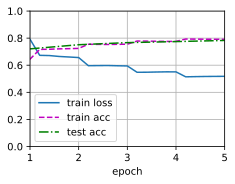

In [27]:
%%time
# around 51 seconds using gpu
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#NLP2-Lecture-4-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>